# **Project Description**

I will be building a machine learning model using the ChEMBL bioactivity data.
I will be performing Descriptor Calculation and Exploratory Data Analysis.

# **Section 1st: Downloading Bioactivity Data**

Installing the ChEMBL web service package to extract bioactivity data from the [*ChEMBL Database*](https://www.ebi.ac.uk/chembl/). ChEMBL has ~ 2.4 Mil componenets as of Aug 2024

In [2]:
#! pip install chembl_webresource_client

# **Importing Libraries**

In [3]:
# Import necessary libraries
import os
import pandas as pd
from chembl_webresource_client.new_client import new_client

# **Target Protein Selection**

### **Protein Target search Coronavirus**
### **Other example can be: Aromatase Protein Target search (Aromatase inhibitors (AIs) are drugs used to lower breast cancer risk)**
### **Acetylcholine Protein target for Alzheimer's disease**
But here I stick with Coronavirus

In [4]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
2,[],Murine coronavirus,Murine coronavirus,14.0,False,CHEMBL5209664,[],ORGANISM,694005
3,[],Canine coronavirus,Canine coronavirus,14.0,False,CHEMBL5291668,[],ORGANISM,11153
4,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
5,[],Human coronavirus OC43,Human coronavirus OC43,13.0,False,CHEMBL5209665,[],ORGANISM,31631
6,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
8,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
9,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


I use single protein for further investigation

### **Extract bioactivity data for *SARS coronavirus 3C-like proteinase* (7th entry) which has the target type of single protein**
I assign the 7th entry (which corresponds to the target protein, *coronavirus 3C-like proteinase*) to the ***selected_target*** variable 

In [5]:
selected_target = targets.target_chembl_id[6]
selected_target

'CHEMBL3927'

I consider only bioactivity data for *coronavirus 3C-like proteinase* (CHEMBL3927) that are reported as IC$_{50}$ values in nM (nanomolar) unit.
the lower IC$_{50}$ value (standard_value) the better the potency of the drug becomes as less concentration of the drug is required to have 50% inhibition capability. Below, activity looks for activity of the small molecules on modulating the specified target protein "selected_target".

In [6]:

activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df.head(3)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5


Finally I save the resulting bioactivity data to a CSV file **bioactivity_data.csv** for further preprocessing before training the ML model.

In [7]:
#df.to_csv('bioactivity_data.csv', index=False)

I transfered the generated data into a folder named "Extracted_ChEMBL_data"!

# **Section 2: Data Preprocessing**

## **Handling missing data**
If any compounds has missing value for the **standard_value** column which is the value of the IC$_{50}$ then drop it

In [8]:
df2 = df[df.standard_value.notna()]
print(df2.shape[0])

133


Fortunately, this dataset has no missing data.

### **Compounds can be divided into 3 labels of being active, inactive or intermediate**
Compounds having values of less than 1000 nM (1mM) are considered to be **active**. Those greater than 10,000 nM are considered to be **inactive**. And, between 1,000 and 10,000 nM are referred to as **intermediate**. 

In [9]:
bioactivity_class = []
for value in df2.standard_value:
    value = float(value)
    if value >= 10000:
        bioactivity_class.append("inactive")
    elif value <= 1000:
        bioactivity_class.append("active")
    else:
        bioactivity_class.append("intermediate")

#bioactivity_class

### **Feature Selection**
Only 4 columns ('molecule_chembl_id', 'canonical_smiles', 'bioactivity_class', 'standard_value') are needed to train the ML model, therefore i create a new dataframe 

In [10]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df3 = df2[selection]
# appending bioactivity_class
bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
df3=pd.concat([df3,bioactivity_class], axis=1)
df3

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


### **Fixing Data Redundancy **
Improving Redundancy in a dataset by removing the same data if repeated multiple times.

In [11]:
# Check and remove duplicate rows
df3_unique = df3.drop_duplicates()
print(df2.shape[0])
print(df3_unique.shape[0])

133
130


Finally I save the resulting bioactivity preprocessed data to a CSV file **bioactivity_preprocessed_data.csv**. it'll be transffered to the folder of "Extracted_ChEMBL_data"

In [12]:
#df3_unique.to_csv('bioactivity_preprocessed_data.csv', index=False)

# **Section 3: Molecular Descripters Computation and Exploratory Data Analysis**

## **Install conda and rdkit**
rdkit is used to compute the molecular descripters for compounds in the dataset previously compiled and preprocessed.  
canonical_smiles in the generated dataset containes the chemical structure information of the compounds.

In [13]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.


## **Load bioactivity dataset**

In [14]:
# Change directory to the folder where the current Jupyter notebook is located
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
os.chdir(notebook_dir)
# Verify the current working directory
#print("Current working directory:", os.getcwd())
df4 = pd.read_csv('Extracted_ChEMBL_data/bioactivity_preprocessed_data.csv')
df4

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
125,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
126,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
127,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
128,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


# **Importing Libraries**

In [15]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

## **Calculation of Lipinski Descriptors**

Christopher Lipinski, a researcher at Pfizer, developed a set of guidelines to assess the **druglikeness** of compounds. This concept of druglikeness is linked to the Absorption, Distribution, Metabolism, and Excretion (ADME) profile, which is also known as pharmacokinetics. Lipinski formulated the **Rule-of-Five** (or **Lipinski's Rule**) based on an analysis of orally active FDA-approved drug
.

The **Rule-of-Five** outlines the following crite (also all the following values are multiples of 5)ria:
* Molecular weight should be less than 500 Dalton.
* Octanol-water partition coefficient (LogP) should be less than 5.
* Number of hydrogen bond donors sholesse fewer than 5.
* Number of hydrogen bond acceptors shlessbe fewer than 10.


### **Calculate descriptors**
as smiles has the exact atomic details of the molecule, therfore is used to collect the molecular descriptors (LogP for solubility, )

In [16]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [17]:
df4_lipinski = lipinski(df4.canonical_smiles)
df4_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
125,338.359,3.40102,0.0,5.0
126,296.366,3.44330,0.0,3.0
127,276.291,4.09564,0.0,3.0
128,278.307,3.29102,0.0,3.0


Here I combine bioactivity class and standard value from database with df4_lipinski data

In [18]:
df4_combined = pd.concat([df4,df4_lipinski], axis=1)
df4_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
125,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
126,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
127,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
128,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

Converting IC50 values to pIC50 compresses the wide range of values, making the data more uniformly distributed and easier to interpret. It also reduces the influence of extreme values and ensures consistency across datasets, aligning with the natural logarithmic behavior of biological processes.

In [19]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [20]:
df4_combined.standard_value.describe()

count        130.000000
mean       79412.525385
std       138814.864118
min           50.000000
25%        10225.000000
50%        17300.000000
75%        64563.990000
max      1000000.000000
Name: standard_value, dtype: float64

In [21]:
-np.log10( (10**-9)* 10000000000 )

np.float64(-1.0)

In [22]:
# a function to put a cap -log10()
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)
        
    return x

df4_norm = norm_value(df4_combined)
df4_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
125,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
126,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
127,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
128,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [23]:
df4_norm.standard_value_norm.describe()

count        130.000000
mean       79412.525385
std       138814.864118
min           50.000000
25%        10225.000000
50%        17300.000000
75%        64563.990000
max      1000000.000000
Name: standard_value_norm, dtype: float64

In [24]:
df4_final = pIC50(df4_norm)
df4_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
125,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
126,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
127,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
128,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [25]:
df4_final.pIC50.describe()

count    130.000000
mean       4.734844
std        0.916526
min        3.000000
25%        4.190342
50%        4.761983
75%        4.990433
max        7.301030
Name: pIC50, dtype: float64

### **Removing the 'intermediate' bioactivity class**
the following comaparion will be only on active and inactive classe, therfore I remove the intermediate ones

In [26]:
df4_2class = df4_final[df4_final.bioactivity_class != 'intermediate']
df4_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
125,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
126,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
127,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
128,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


## **Section 3: Chemical space analysis (Exploratory Data Analysis) (Chemical Space Analysis) via Lipinski descriptors**
EDA involves summarizing the main characteristics of a dataset, often with visual methods. It helps to uncover patterns, spot anomalies, and test hypotheses with summary statistics and graphical representations.

In [27]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 'active' and 'inactive' bioactivity classes**

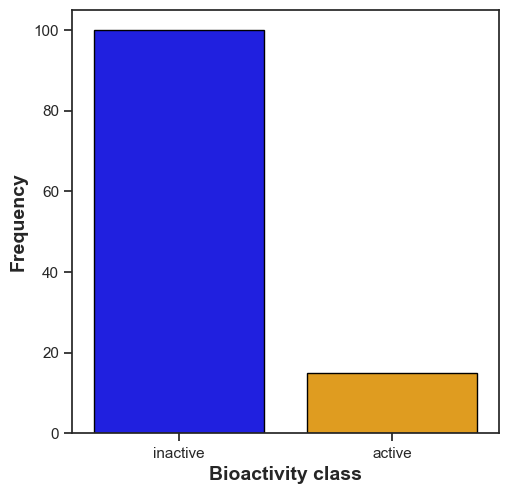

In [28]:
plt.figure(figsize=(5.5, 5.5))

# Use hue to differentiate the classes and color them accordingly
sns.countplot(x='bioactivity_class', data=df4_2class, edgecolor='black', hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)

# Remove the legend since we don't need it for this purpose
plt.legend([],[], frameon=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')


### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

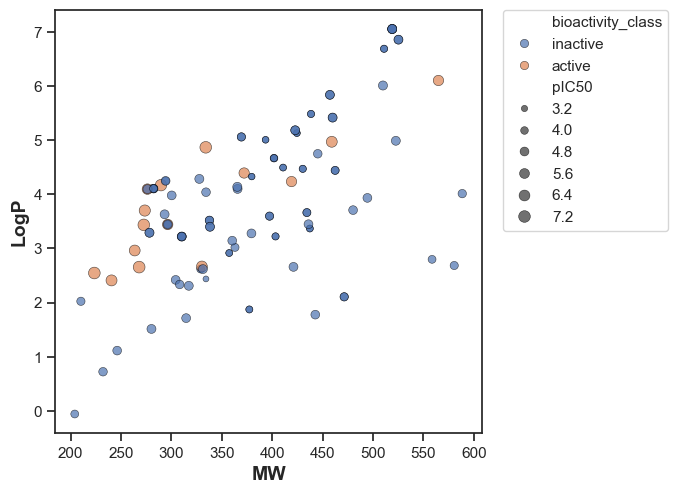

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df4_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**
#### **pIC50 value**

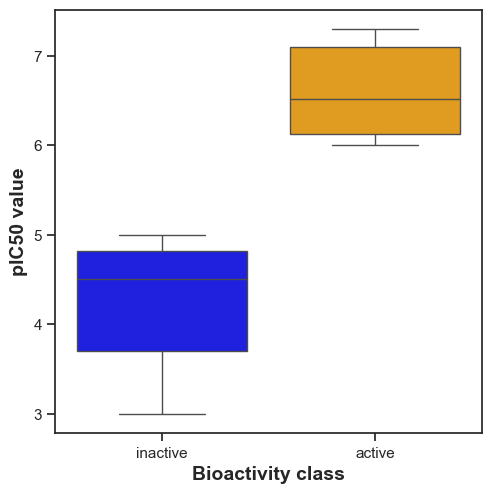

In [34]:
plt.figure(figsize=(5.5, 5.5))

# Use hue to differentiate the classes and color them accordingly
sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data=df4_2class, hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)
#sns.countplot(x='bioactivity_class', data=df4_2class, edgecolor='black', hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

Mann-Whitney U Test: Compares the active and inactive samples using the Mann-Whitney U test to determine if there is a significant difference in their distributions.

In [40]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df4_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df4_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

p-value is used to determine whether to reject the null hypothesis (H0), which states that the distributions are the same. If the p-value is less than the significance level (alpha = 0.05), it indicates a significant difference between the distributions.

In [41]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1500.0,4.800250e-10,0.05,Different distribution (reject H0)


#### **MW**

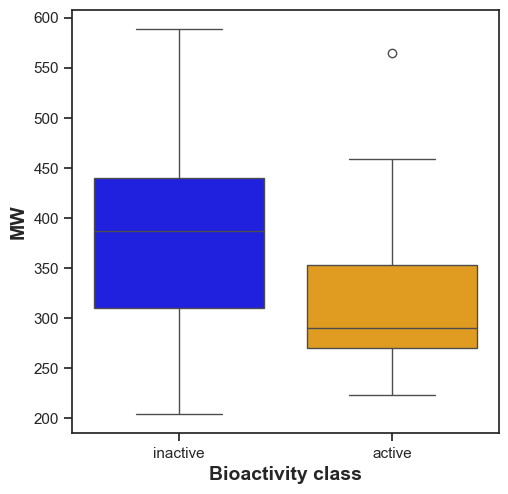

In [42]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data=df4_2class, hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [43]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,400.5,0.003747,0.05,Different distribution (reject H0)


#### **LogP**

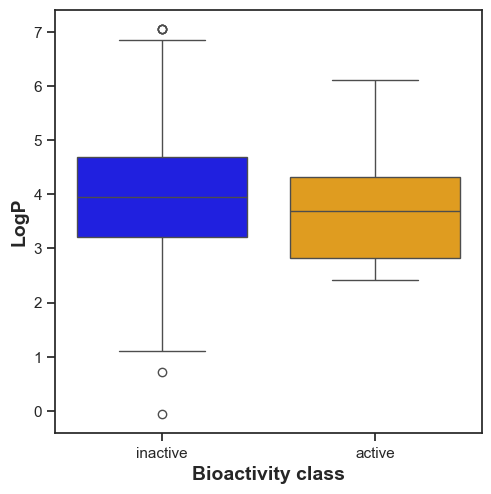

In [44]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data=df4_2class, hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [45]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,694.5,0.647804,0.05,Same distribution (fail to reject H0)


Since the p-value (0.647804) is greater than 0.05, it fails to reject the null hypothesis. This suggests that the LogP values for active and inactive compounds are similarly distributed, meaning that LogP may not be a distinguishing factor between these two classes in your dataset.

#### **NumHDonors**

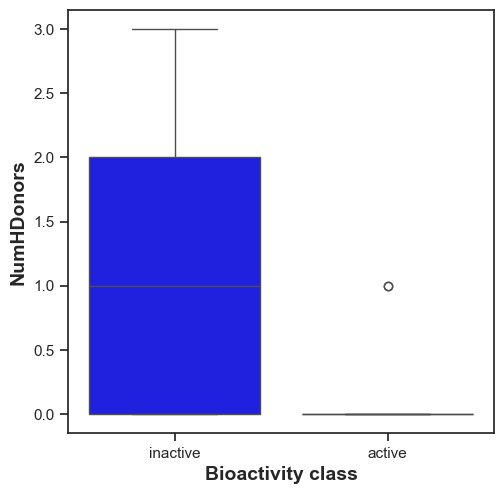

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data=df4_2class, hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [47]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,297.5,0.000072,0.05,Different distribution (reject H0)


Since the p-value (0.000072) is much smaller than 0.05, it rejects the null hypothesis. This indicates that the NumHDonors values for active and inactive compounds are different, suggesting that NumHDonors is a significant factor in distinguishing between these two classes.

#### **NumHAcceptors**

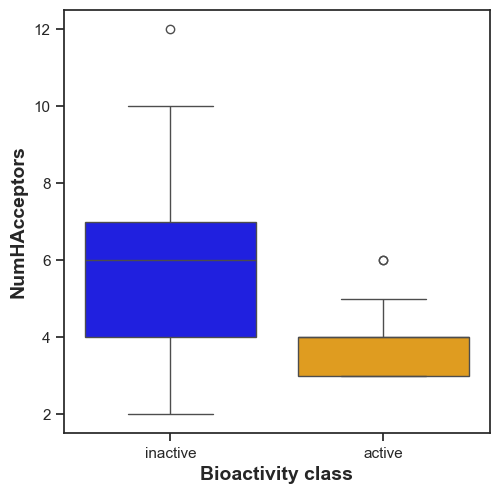

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data=df4_2class, hue='bioactivity_class', palette={'active': 'orange', 'inactive': 'blue'}, dodge=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [49]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,413.0,0.004651,0.05,Different distribution (reject H0)


#### **Statistical Results Interpretation**

##### **Box Plots**

###### **pIC50 Values**

Examining pIC50 values reveals a ***statistically significant difference*** between **actives** and **inactives**. This result aligns with expectations since actives and inactives were defined using threshold values (``IC50 < 1,000 nM`` for actives and ``IC50 > 10,000 nM`` for inactives, corresponding to ``pIC50 > 6`` and ``pIC50 < 5`` respectively).

###### **Lipinski's Descriptors**

Among the 4 Lipinski descriptors (MW, LogP, NumHDonors, NumHAcceptors), only LogP showed ***no significant difference*** between **actives** and **inactives**. The other 3 descriptors (MW, NumHDonors, and NumHAcceptors) exhibited a ***statistically significant difference*** between the two groups.
